In [113]:
%matplotlib inline

In [114]:
import numpy as np
import matplotlib.pyplot as pl
from pylab import rcParams
rcParams['figure.figsize'] =  14,10
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

## Parametros de Sistemas y Pulso de Muestreo 

In [115]:
fB = 32e9;	# Velocidad de simbolos (baud rate)
T = 1/fB; # Tiempo entre simbolos
M = 8;  #Factor de sobremuestreo
fs = fB*M;	# Sample rate

beta = .95001#; %Factor de roll-off
L = 10;  # 2*L*M+1 es el largo del filtro sobremuestreado
t = np.arange(-L,L,1./M)*T#[-L:1/M:L]*T;
n_delay_filter = L*M# %Retardo del filtro
def gen_filter():
    return [np.sinc(t2/T)*np.cos(np.pi*beta*t2/T)/(1-4*beta**2*t2**2/T**2) for t2 in t];
    
gn=gen_filter()

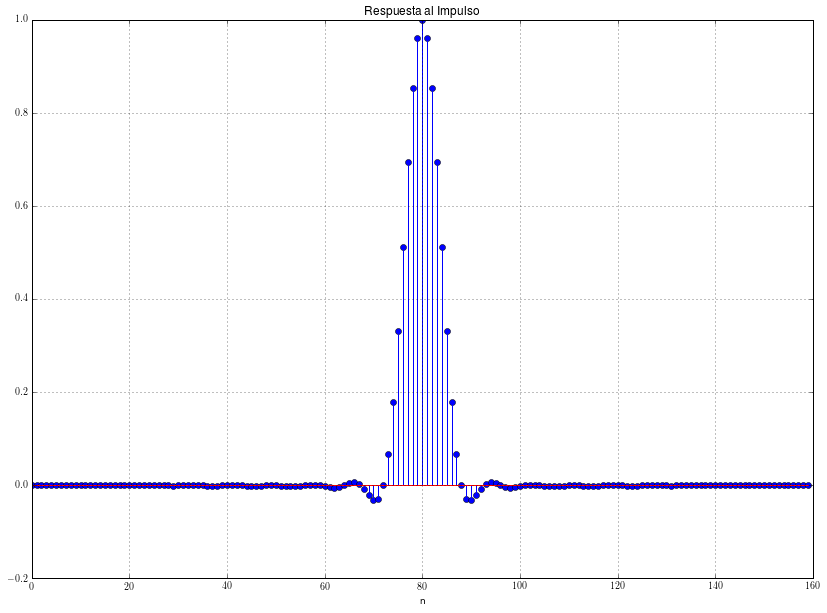

In [116]:
#pl.figure(figsize=(14,10))
pl.stem(gn)
pl.title('Respuesta al Impulso');
pl.xlabel('n');
pl.grid()
pl.draw()

## Transformador de Hilbert

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


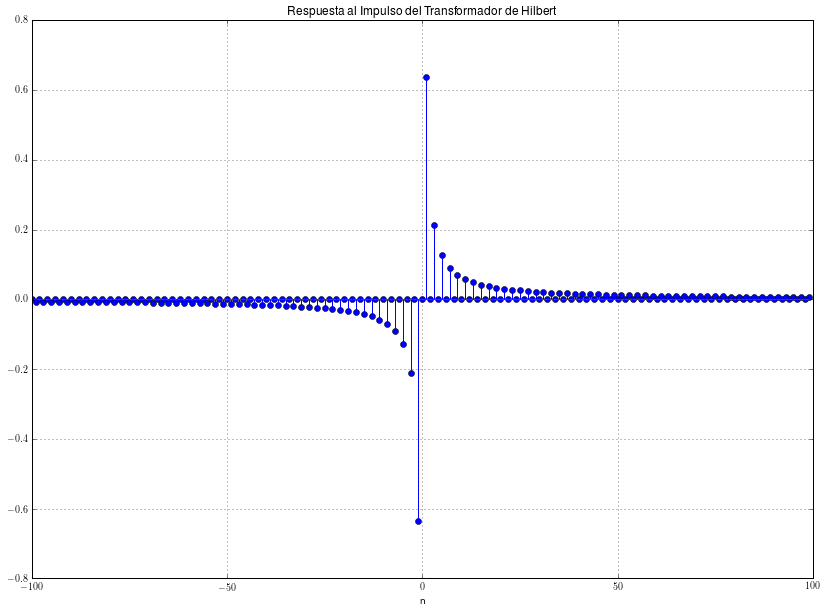

In [117]:
Lf=100;
n=np.arange(-Lf,Lf,1);
n_delay_Hilbert_filter = Lf; #Retardo del filtro de Hilbert
fn = (2*np.sin(np.pi*n/2)**2)/(np.pi*n);
fn[Lf]=0;
h = pl.stem(n,fn);
pl.title('Respuesta al Impulso del Transformador de Hilbert');
pl.xlabel('n');
pl.grid(True)
pl.draw()


In [118]:
def sweep_omega():
    Omega = np.arange(-1,1,1./2**8)*np.pi;
    N = 1000;
    H_Mag=[]                  
    H_Fase=[]
    for omega in Omega:
        xn = [np.exp(np.complex(0,omega*n)) for n in xrange(N)];
        yn = np.convolve(xn,fn);
        H_Mag.append( np.abs(yn[N/2]))
        H_Fase.append(np.angle(yn[N/2]*np.conj(xn[N/2-n_delay_Hilbert_filter])))
    return Omega,H_Mag,H_Fase
Omega,H_Mag,H_Fase=sweep_omega()



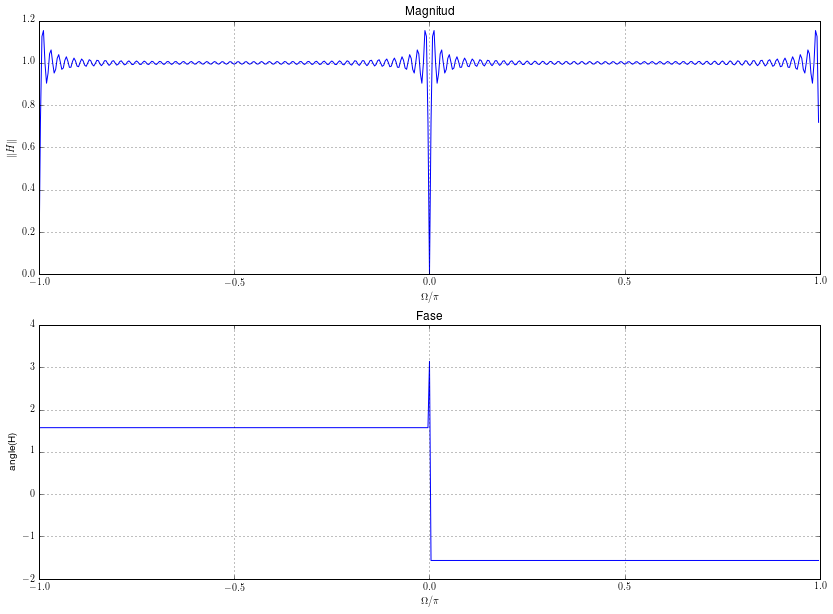

In [54]:
def plot_omega():
    pl.subplot(2,1,1)
    pl.plot(Omega/np.pi,H_Mag);
    pl.title('Magnitud');
    pl.ylabel('$\|H\|$')
    pl.xlabel('$\Omega/\pi$');
    pl.grid()
    pl.subplot(2,1,2) 
    pl.plot(Omega/np.pi,H_Fase);
    pl.title('Fase');
    pl.ylabel('angle(H)')
    pl.xlabel('$\Omega/\pi$');
    pl.grid(True)
    pl.draw()
plot_omega()

# Generacion Simbolos Complejos


In [119]:
n_symbols = 1000;
def gen_symbols():
    ak = [2*np.complex(np.random.randint(2),np.random.randint(2))-np.complex(1,1) for i in xrange(n_symbols)]
    xn= [np.complex(0,0) for i in xrange(M*n_symbols)]
    xn[::M]=ak
    return xn
xn=gen_symbols()

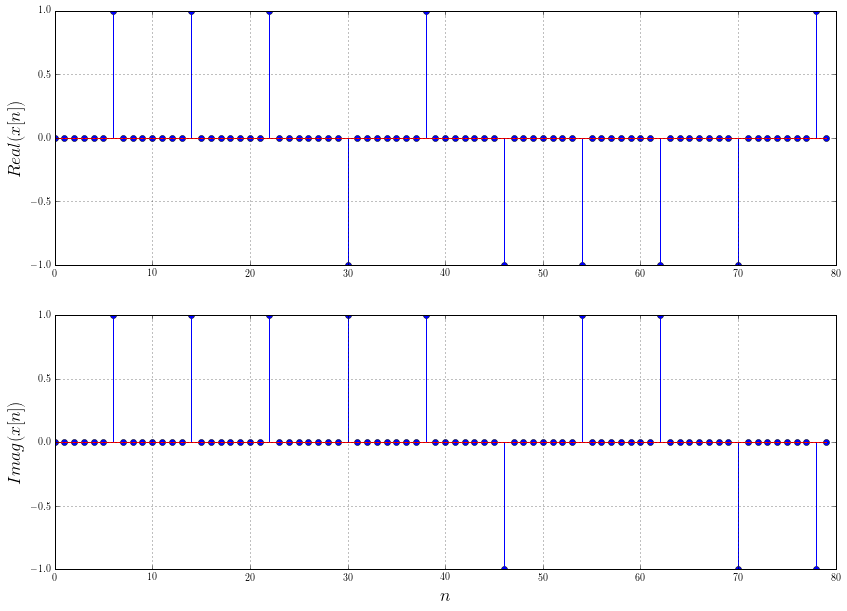

In [120]:
pl.subplot(2,1,1)
pl.grid(True)
pl.stem(np.real(xn[10:10+M*10]))
pl.ylabel('$Real(x[n])$',fontsize=18)
pl.subplot(2,1,2)
pl.grid(True)
pl.stem(np.imag(xn[10:10+M*10]))
pl.ylabel('$Imag(x[n])$',fontsize=18)

pl.xlabel('$n$',fontsize=18);

pl.draw()

## Señal Transmitida


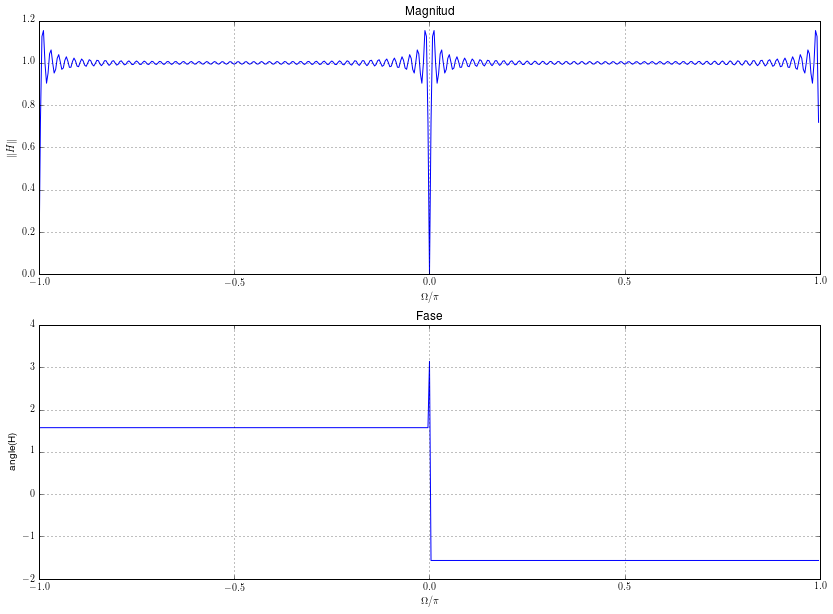

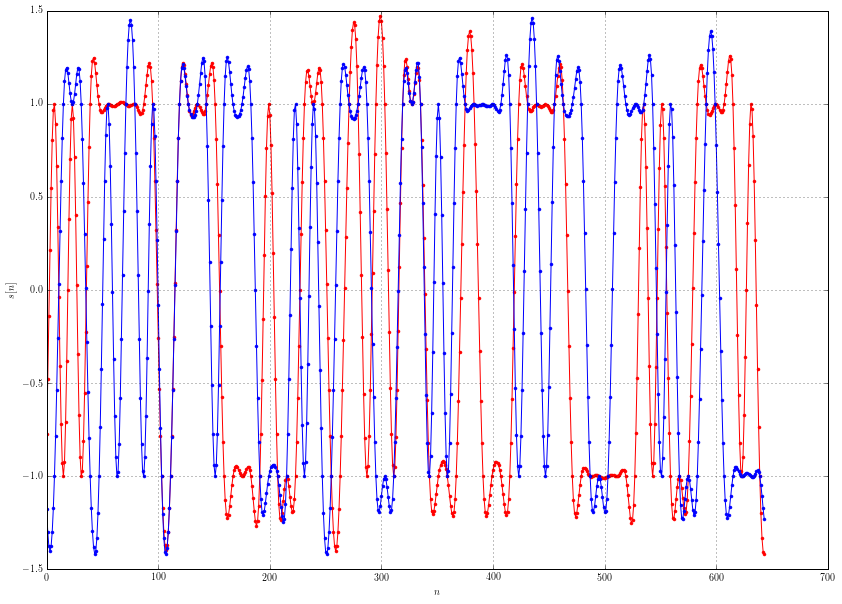

In [121]:
def yn_convolve():
    return np.convolve(xn,gn,mode='full');
    
def plot_time(sn):
    pl.figure()
    pl.plot(np.real(sn[(2*L*M+1):(2*L*M+1)*5]),'r.-');
    pl.plot(np.imag(sn[(2*L*M+1):(2*L*M+1)*5]),'.-');
    pl.ylabel('$s[n]$')
    pl.xlabel('$n$');
    pl.grid(True)

beta=0.51
sweep_omega()
plot_omega()
gn=gen_filter()
yn=yn_convolve()
plot_time(yn)
pl.draw()

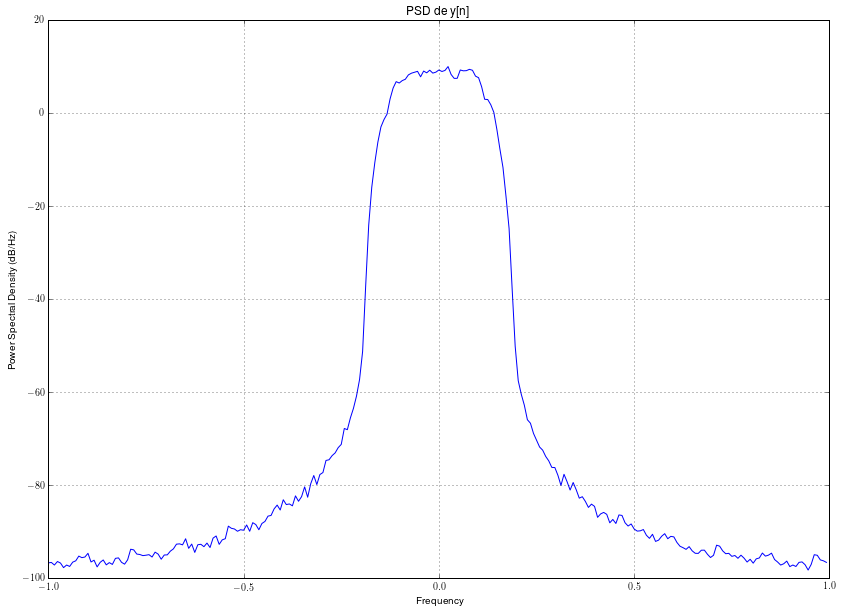

In [122]:
def plot_eye(sn):
    pl.figure()
    d = 5; #Delay para centrar el ojo
    pl.hold(True)
    for m in range( 2*L,n_symbols-(2*L+1)):
        sn_p = sn[m*M+d-1:m*M+d+M];
        pl.plot(range(-M/2,M/2+1),np.real(sn_p),'b')
        pl.plot(range(-M/2,M/2+1),np.imag(sn_p),'r')
        
(Pxx,freqs)=pl.psd(yn)
pl.title('PSD de y[n]')

## Funciones de modulacion y demodulacion

In [123]:
def modulate(omega,yn):
    return [yn[n]*np.e**np.complex(0,omega*n)for n in xrange(len(yn))]
def demodulate(omega,yn):
    return [yn[n]*np.conj(np.e**np.complex(0,omega*n))for n in xrange(len(yn))]

## Generacion de señal analitica 

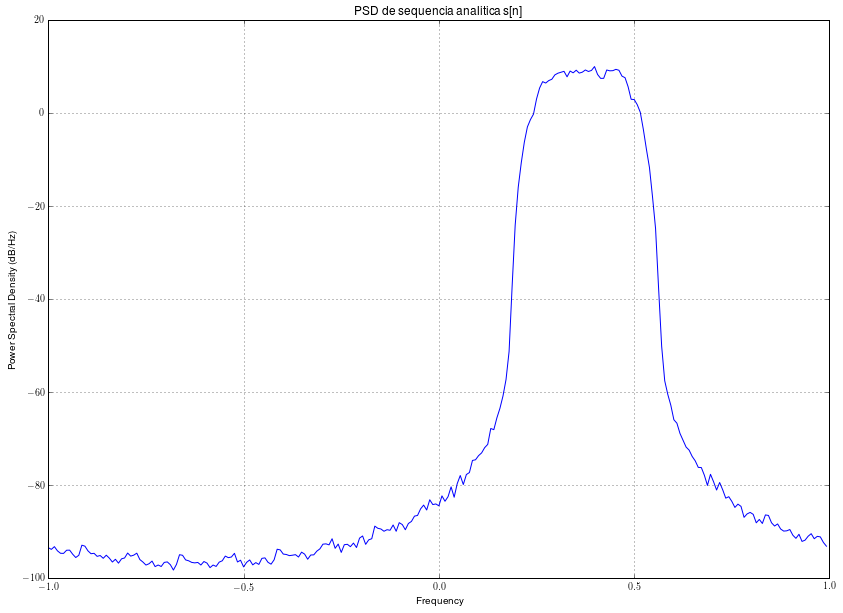

In [124]:
sn=modulate(3*np.pi/M,yn)
(a,b)=pl.psd(sn,sides='twosided')
pl.title('PSD de sequencia analitica s[n]')
pl.draw()

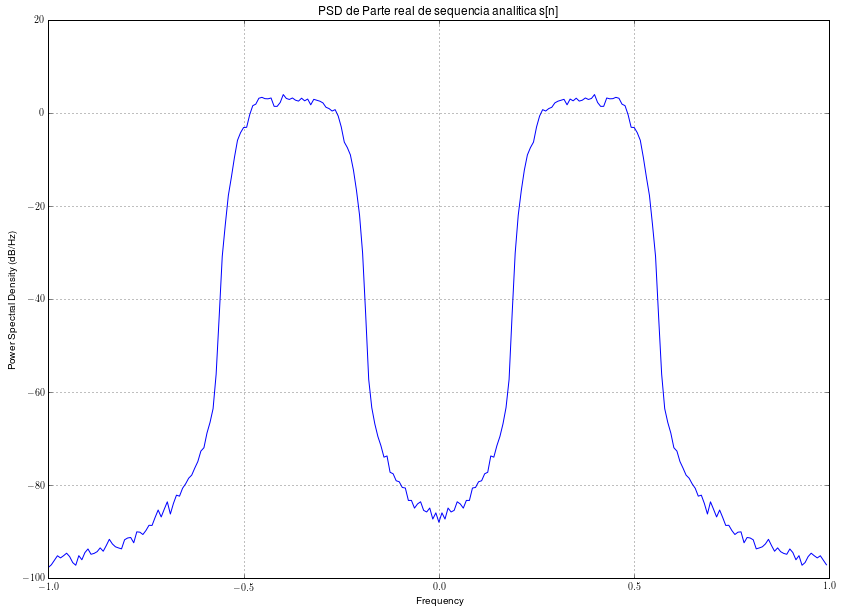

In [125]:
sn_r=np.real(sn)
(a,b)=pl.psd(sn_r,sides='twosided')
pl.title('PSD de Parte real de sequencia analitica s[n]')
pl.draw()

## Procesamiento de señal real analítica por Transformador de Hilbert

In [126]:
sn_i=np.convolve(fn,sn_r,mode='full')
len(sn_i),len(sn_r),len(gn)


(8358, 8159, 160)

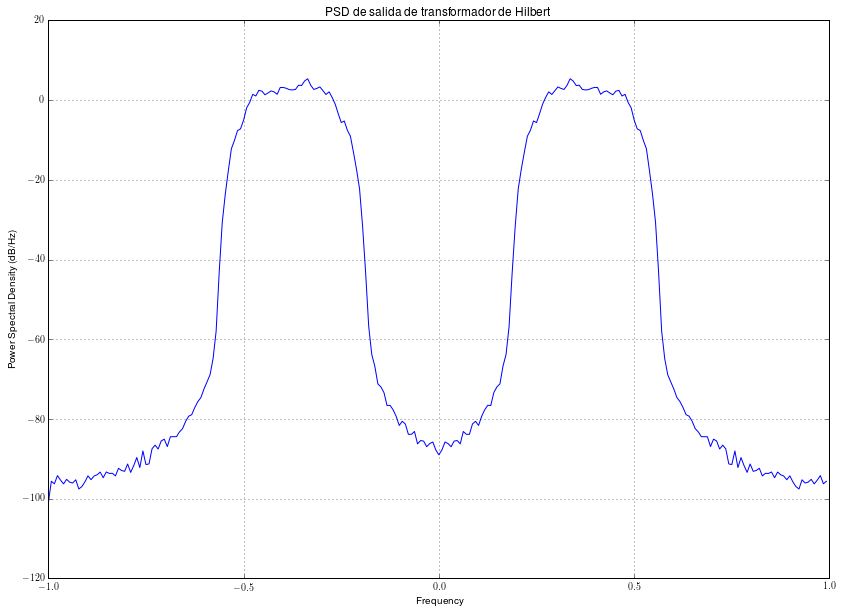

In [127]:
(a,b)=pl.psd(sn_i,sides='twosided')
pl.title('PSD de salida de transformador de Hilbert')
pl.draw()

## Obtencion de s[n] original sumando salida de Hilbert con R{s[n]}

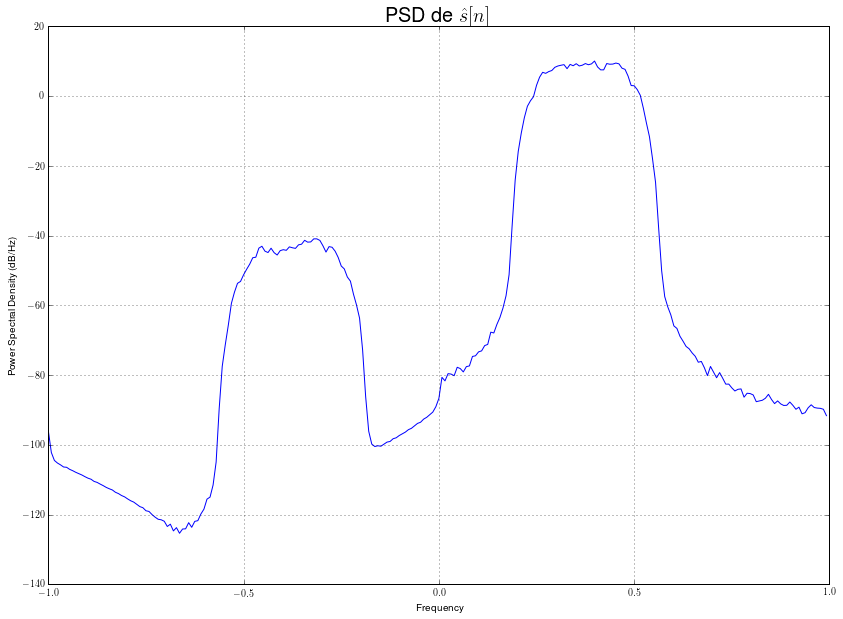

In [128]:
sn_hat = sn_r+np.complex(0,1)*sn_i[Lf:-(Lf-1)]
from scipy import signal  
(a,b)=pl.psd(sn_hat, window=None, sides='twosided')
pl.title('PSD de '+ r'$\hat{s}[n]$',fontsize=20)
pl.draw()

## Comparacion de  partes imaginarias 

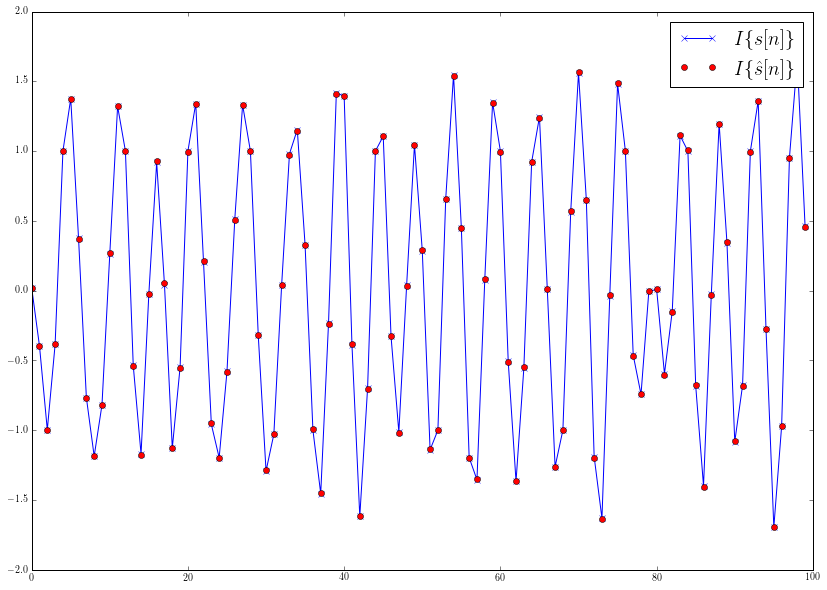

In [129]:

pl.plot(np.imag(sn)[500:600],'bx-',label=r'$I\{s[n]\}$')
pl.plot(sn_i[Lf+500:Lf+600],'or',label=r'$I\{\hat{s}[n]\}$')
pl.legend(fontsize=20)
pl.draw()

## Comparacion de PSD de señal transmitida y señal recuperada
Con 1000 taps de transformador de Hilbert la imagen de la señal que aparece entre F=-1,-0.5 esta por debajo de la ventana de PSD de la señal original. 

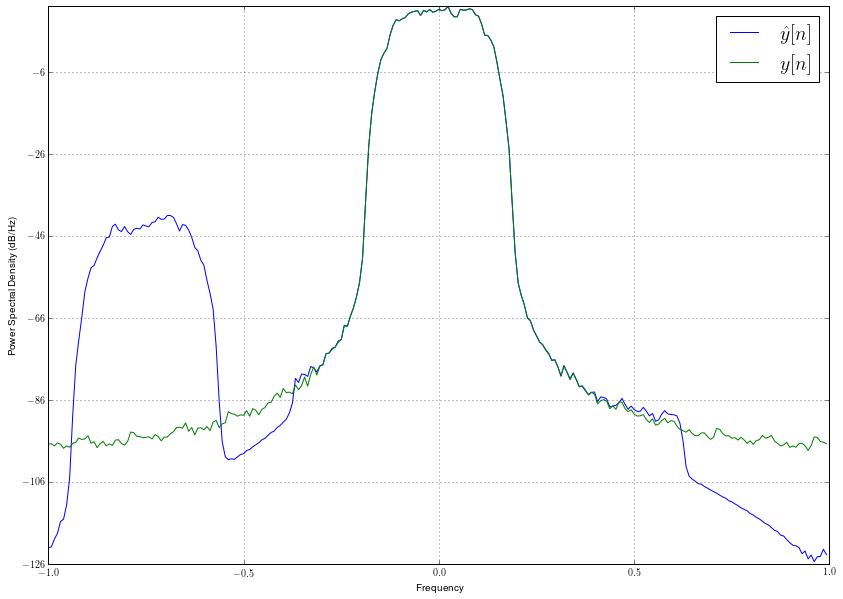

In [130]:
yn_hat=demodulate(3*np.pi/M,sn_hat)
(a,b)=pl.psd(yn_hat,label=r'$\hat{y}[n]$')
(a,b)=pl.psd(yn,label=r'$y[n]$')
pl.legend(fontsize=20)
pl.draw()

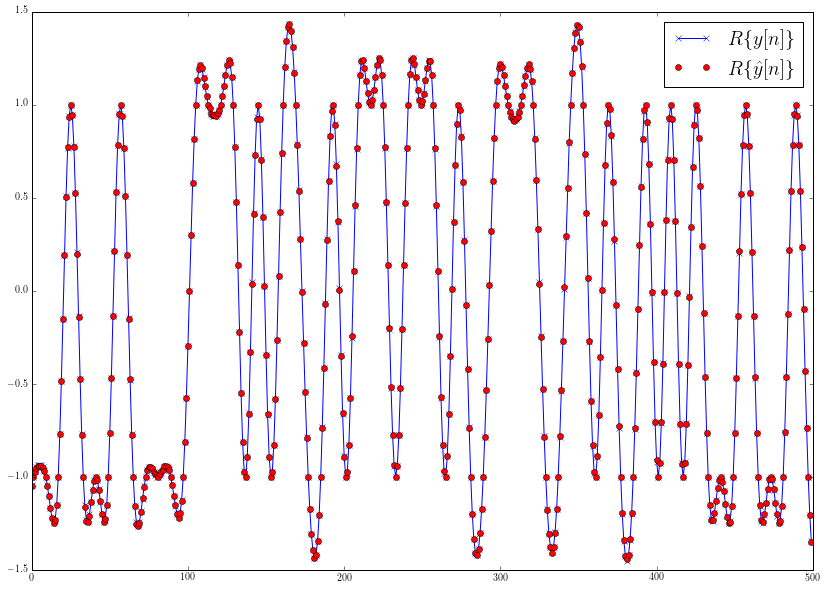

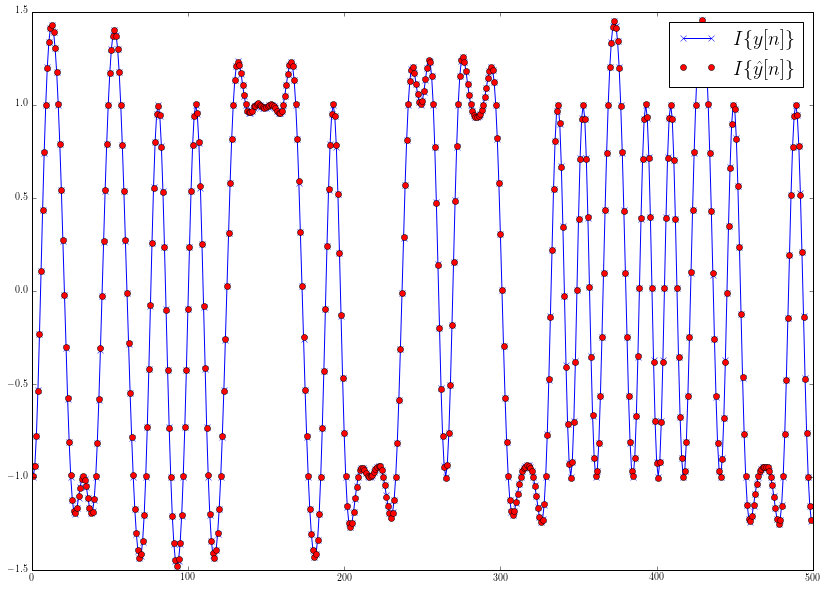

In [131]:
pl.plot(yn[-1000:-500],'bx-',label=r'$R\{y[n]\}$')
pl.plot(yn_hat[-1000:-500],'ro',label=r'$R\{\hat{y}[n]\}$')
pl.legend(fontsize=20)
pl.figure()

pl.plot(np.imag(yn[-1000:-500]),'bx-',label=r'$I\{y[n]\}$')
pl.plot(np.imag(yn_hat[-1000:-500]),'ro',label=r'$I\{\hat{y}[n]\}$')
pl.legend(fontsize=20)
pl.draw()



## Verificacion de la energia del modulo al cuadrado de una señal transmitida

Señal transmitida es $$p[n]=\sum_{k} a_kg[n-kM],a_k=[-1,1]$$


Se desea calcular $E\{\|p[n]\|^2\}$, entonces $$\|p[n]\|^2=p[n]p^{\ast}[n]$$
$$ \|p[n]\|^2=\sum_{k} a_kg[n-kM]\sum_{k'} a^{\ast}_{k'}g^{\ast}[n-k'M]$$
$$ \|p[n]\|^2=\sum_{k} \sum_{k'}a_{k }a^{\ast}_{k'}g[n-kM]g^{\ast}[n-k'M]$$
El valor de $E\{a_k a_{k'}^{\ast}\}$ solo existe cuando $k=k'$ entonces,
$$ E\{\|p[n]\|^2\}=\sum_{k}E\{a_{k }a^{\ast}_{k}\}\|g[n-kM]\|^2$$
$$ E\{\|p[n]\|^2\}=\sum_{k}E\{\|a_{k }\|^2\}\|g[n-kM]\|^2$$
y como habiamos asumido $E\{\|a_{k }\|^2\}=1$,
$$ E\{\|p[n]\|^2\}=\sum_{k}\|g[n-kM]\|^2$$






### Verificamos que $E\{\|p[n]\|^2\}$ sea periodica en M

$$ E\{\|p[n+M]\|^2\}=\sum_{k}\|g[n-kM+M]\|^2$$
$$ E\{\|p[n+M]\|^2\}=\sum_{k}\|g[n-(1-k)M]\|^2$$
Haciendo $l=1-k$,
$$ E\{\|p[n+M]\|^2\}=\sum_{l}\|g[n-lM]\|^2$$
Todos las sumas en $k$ equivalen a todas las sumas en $l$ por lo tanto

$$\sum_{k}\|g[n-kM]\|^2=\sum_{l}\|g[n-lM]\|^2$$
$$E\{\|p[n]\|^2\}=E\{\|p[n+M]\|^2\}$$






### Verificacion de la Serie de Fourier de $E\{\|p[n]\|^2\}$ 

Por definicion los coeficientes de la serie de Fourier de una señal periodica de periodo M pueden calcularse a traves de la Transformada Discreta de Fourier mediante la siguiente relacion
$$ b_k= \frac{1}{M}\Bbb{X}(e^{j\Omega})\Big|_{\Omega=\frac{k2\pi}{M}}$$
Entonces debemos encontrar la Transformada de un periodo de $E\{\|p[n]\|^2\}$ y encontrar los valores de sus coeficientes.   
Sea $x[n]=g[n]g^\ast[n]$, podemos obtener $\Bbb{X}(e^{j\Omega})$ mediante la convolucion circular de las transformadas de $g[n]=\Bbb{G}(e^{j\Omega})$ y $g^\ast[n]=\Bbb{G}^\ast(e^{-j\Omega})$ y valuarlas en $\Omega=\frac{k2\pi}{M}$.
        $$\Bbb{X}(e^{j\Omega})=\frac1{2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast(e^{j(\theta - \Omega)})d\theta$$
 Entonces para obtener $b_k$,
 $$b_k=\frac1{M2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast(e^{j(\theta - \Omega)})d\theta\Big|_{\Omega=\frac{k2\pi}{M}}$$

 $$b_k=\frac1{M2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast(e^{j(\theta - \frac{k2\pi}{M})})d\theta$$





### Verifique que si $β < 1$ (i.e., el exceso de ancho de banda es menor que 100 %) 
$$ E\{\|p[n]\|^2\}=b_0 + 2\Re{\{b_1 e^{j\frac{2\pi}{M}n}\}}$$ 
 

Al obtener los coeficientes de Fourier de la señal vemos que para $k=0$:
$$b_0=\frac{1}{M2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast(e^{j\theta})d\theta $$
$$b_0=\frac{1}{M2\pi}\int_{2\pi}\|\Bbb{G}(e^{j\theta})\|^2d\theta $$
Para $k=1$:
$$b_1=\frac{1}{M2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast\big(e^{j(\theta-\frac{2\pi}{M})}\big)d\theta $$
Para $k=2$:
$$b_2=\frac{1}{M2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast\big(e^{j(\theta-\frac{4\pi}{M})}\big)d\theta $$

A partir de que $\beta<1$ sabemos que $G(e^{j\Omega})=0,\Omega>\frac{2\pi}{M}$, por lo tanto $b_k,k>=2$ no tendra valores ya que el solapamiento de $G(e^{j\Omega})$ con sus desplazamientos mayores o iguales a $\frac{4\pi}{M}$ es nulo.

Por otro lado al ser $ E\{\|p[n]\|^2\}$ periodica y real, $b_1=b_{-1}^{\ast}$
$$ E\{\|p[n]\|^2\}=b_0+b_1e^{(j\frac{2\pi}{M}n)}+b_1^{\ast}e^{(-j\frac{2\pi}{M}n)}$$

$$ E\{\|p[n]\|^2\}=b_0+2\Re{(b_1)}cos(\frac{2\pi}{M}n)-2\Im{(b_1)}sin(\frac{2\pi}{M}n)$$
$$ E\{\|p[n]\|^2\}=b_0+2\Re\big(b_1e^{(j\frac{2\pi}{M}n)}\big)$$




### Plot del tono de timing

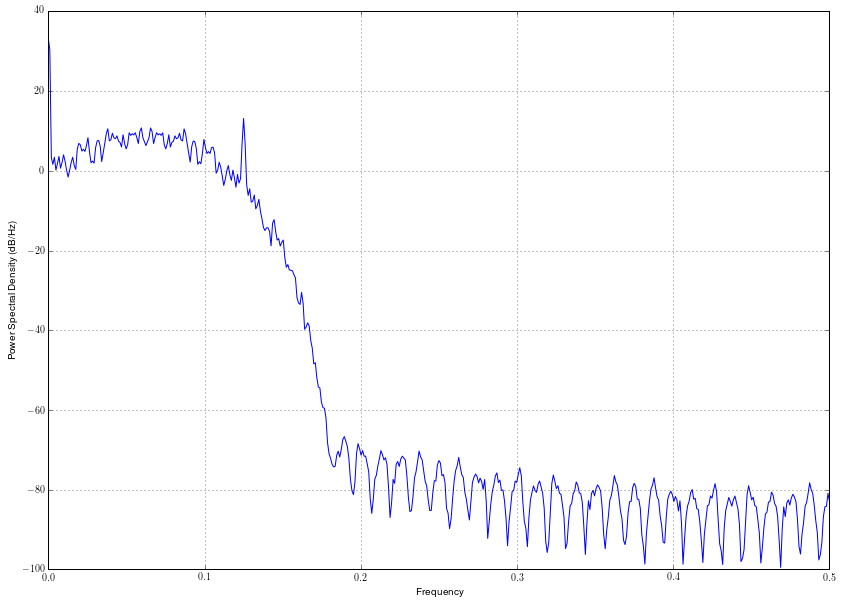

In [162]:
from scipy import signal
yn
z=np.abs(yn)**2
#pl.psd(z,scale_by_freq=True)
pl.psd(z, NFFT=2**10, Fs=1, window=signal.get_window('hanning',2**10))


pl.draw()

## Agrego señal $\tilde{p}[n]$ a $p[n]$ y verifico que tono de timing desaparece

Ahora la señal transmitida es $\tilde{p[n]}=\sum_{k} a_kg[n-kM-n_d],a_k=[-1,1]$ siendo $n_d$ un delay.
Antes para calcular los coeficientes de la serie usabamos
$$ b_k= \frac{1}{M}\Bbb{X}(e^{j\Omega})\Big|_{\Omega=\frac{k2\pi}{M}}$$


$$b_k=\frac1{M2\pi}\int_{2\pi}\Bbb{G}(e^{j\theta})\Bbb{G}^\ast(e^{j(\theta - \Omega)})d\theta\Big|_{\Omega=\frac{k2\pi}{M}}$$



Pero ahora con el delay $n_d=\frac M2$, $F\big(g[n-n_d]\big)\rightarrow e^{-j\Omega n_d}\Bbb{G}(e^{j\Omega})$
$$ b'_k= \frac{e^{-j\Omega n_d}}{M}\Bbb{X}(e^{j\Omega})\Big|_{\Omega=\frac{k2\pi}{M}}$$
$$ b'_k= \frac{e^{-j\Omega\frac{M}{2}}}{M}\Bbb{X}(e^{j\Omega})\Big|_{\Omega=\frac{k2\pi}{M}}$$
Reemplazo en la exponencial $\Omega=\frac{k2\pi}{M}$
$$ b'_k= \frac{e^{-j\frac{k2\pi}{M}\frac{M}{2}}}{M}\Bbb{X}(e^{j\Omega})\Big|_{\Omega=\frac{k2\pi}{M}}$$
$$ b'_k= \frac{e^{-jk\pi}}{M}\Bbb{X}(e^{j\Omega})\Big|_{\Omega=\frac{k2\pi}{M}}$$
$$ b'_k= e^{-jk\pi}b_k$$


Como vimos que cuando $\beta<1$ solo existen $b_0,b_1,b_{-1}$
$$ b'_1= e^{-j\pi}b_1=-b_1$$
$$ b'_{-1}= e^{j\pi}b_{-1}=-b_{-1}$$



$$ E\{\|\tilde{p}[n]\|^2\}=b_0-b_1e^{(j\frac{2\pi}{M}n)}-b_1^{\ast}e^{(-j\frac{2\pi}{M}n)}$$
$$ E\{\|\tilde{p}[n]\|^2\}=b_0-(b_1e^{(j\frac{2\pi}{M}n)}+b_1^{\ast}e^{(-j\frac{2\pi}{M}n)})$$
Reemplazando los terminos en los que aparecen $b_1$ y $b_{-1}$ de la formula de $E\{\|{p}[n]\|^2\}$
$$ E\{\|\tilde{p}[n]\|^2\}=b_0-2\Re\big(b_1e^{(j\frac{2\pi}{M}n)}\big)$$









In [177]:
beta=0.51
gn=gen_filter()
xn=gen_symbols()
delay=M/2
xxn=yn_convolve()[delay:]
yyn=(xxn+yn[:-delay])/2
len(yyn)

8155

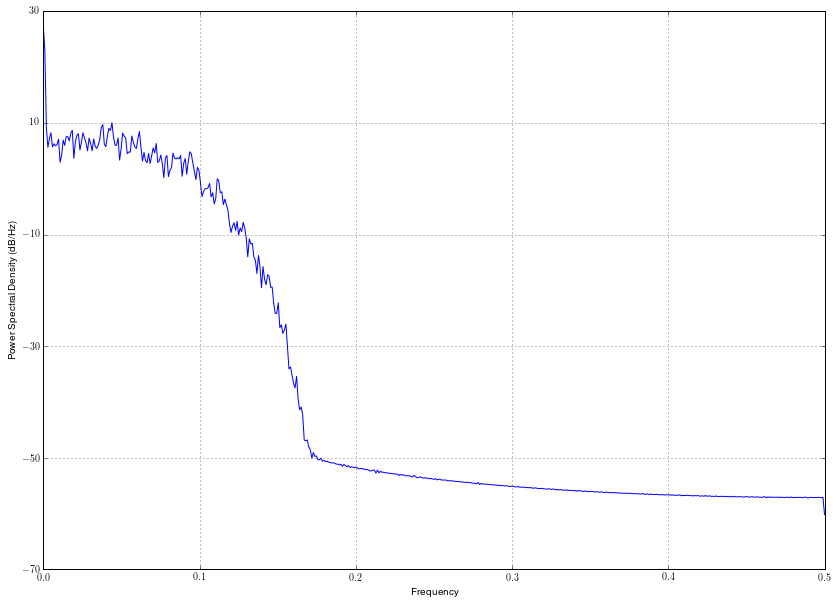

In [178]:
zz=np.abs(yyn)**2
pl.psd(zz, NFFT=2**10, Fs=1, window=signal.get_window('hamming',2**10))
pl.draw()

### Demostracion que con $B$ muy chico el tono de timing de desvanece y puede surgir con $\|x[n]\|^4$

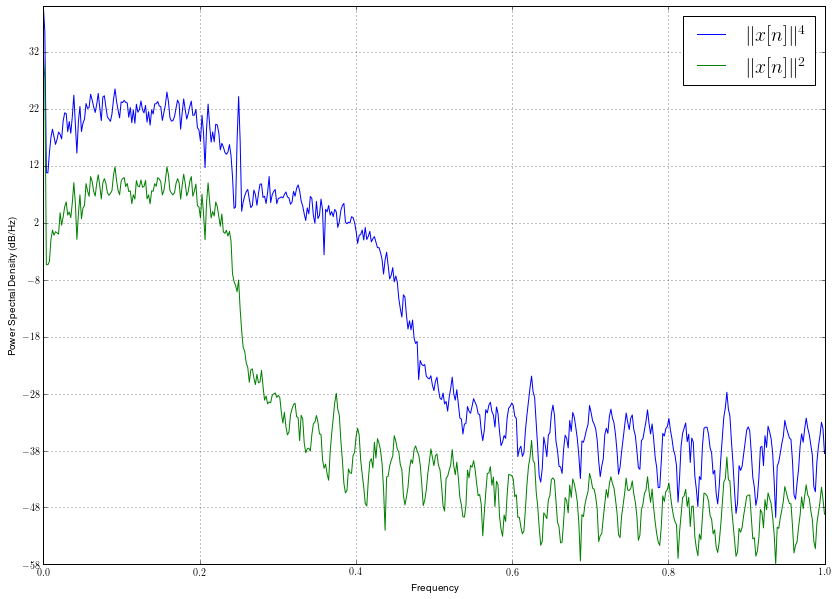

In [190]:
beta=0.051
gn=gen_filter()
xn=gen_symbols()
xxn=yn_convolve()
zz=np.abs(xxn)**4
zzz=np.abs(xxn)**2
pl.psd(zz, NFFT=2**10, Fs=2, window=signal.get_window('hamming',2**10),label=r'$\|x[n]\|^4$')
pl.psd(zzz, NFFT=2**10, Fs=2, window=signal.get_window('hamming',2**10),label=r'$\|x[n]\|^2$')
pl.legend(fontsize=20)


pl.draw()